In [1]:
import torch
is_available = torch.cuda.is_available()
print(f"Is GPU available?  {is_available}")

Is GPU available?  True


In [5]:
pip install pandas numpy scikit-learn imbalanced-learn transformers datasets matplotlib seaborn nltk jupyter joblib deep-translator accelerate deep-translator langdetect optuna

  Using cached datasets-4.4.1-py3-none-any.whl (511 kB)
  Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
  Using cached dill-0.4.0-py3-none-any.whl (119 kB)
  Using cached click-8.3.0-py3-none-any.whl (107 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\PKK\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/networkx-3.5-py3-none-any.whl (2.0 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\PKK\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
# --- 1. Core Data Handling Libraries ---
import pandas as pd
import numpy as np
import os
import pickle
import re

# --- 2. Plotting Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Data Preprocessing & Splitting ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler #
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # Download stopwords data for cleaning

# --- 4. Model Training (Hugging Face Transformers) ---
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments
)

# --- 5. Model Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)

# --- 6. (For Later) Translation Library ---
from deep_translator import GoogleTranslator

# --- 7. (NEW) Language Detection Library ---
from langdetect import detect, DetectorFactory

print("All libraries imported.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PKK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


All libraries imported.


# Load Dataset

In [3]:
data = pd.read_csv("./Combined Data.csv")

In [4]:
data.dropna(inplace = True)
data

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [5]:
data.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data = data.sample(n = 6000, random_state = 42).reset_index(drop = True)

In [6]:
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


# Data Preprocessing

In [6]:
# --- 3. Define and Apply Text Cleaning ---

# Note: All imports (re, nltk, stopwords) and the 'stop_words' variable
# should already be in your main import cell from Step 1.

def clean_statement(text):
  """
  Applies text cleaning:
  1. Lowercases text
  2. Removes all non-alphabetic characters
  3. Removes English stopwords
  4. Strips extra whitespace
  """
  # Convert to string (just in case) and lowercase
  text = str(text).lower()
  
  # Remove everything except letters and spaces
  text = re.sub(r"[^a-zA-Z\s]", "", text)
  
  # Remove stopwords
  text = ' '.join([word for word in text.split() if word not in stop_words])
  
  # Remove extra spaces
  text = re.sub(r"\s+", " ", text).strip()
  
  return text

# --- Test the function with an example ---
test_text = "O ererp o i love to east Banna 123!!"
print(f"Original test text: '{test_text}'")
print(f"Cleaned test text:  '{clean_statement(test_text)}'")

# --- Apply the cleaning function to the DataFrame ---
print("\nApplying cleaning function to 'statement' column...")
data['statement'] = data['statement'].apply(clean_statement)

# Display the head to confirm the changes
print("Cleaning complete. DataFrame head:")
display(data.head())

Original test text: 'O ererp o i love to east Banna 123!!'
Cleaned test text:  'ererp love east banna'

Applying cleaning function to 'statement' column...
Cleaning complete. DataFrame head:


,statement,status
0,oh gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,wrong back dear forward doubt stay restless re...,Anxiety
3,ive shifted focus something else im still worried,Anxiety
4,im restless restless month boy mean,Anxiety


In [7]:
data['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X = data.drop('status', axis=1)
y = data['status']

X_resampled, y_resampled = ros.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [9]:
print(data['status'].value_counts())

status
Anxiety                 16343
Normal                  16343
Depression              16343
Suicidal                16343
Stress                  16343
Bipolar                 16343
Personality disorder    16343
Name: count, dtype: int64


In [10]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])
data

,statement,status,label
0,oh gosh,Anxiety,0
1,trouble sleeping confused mind restless heart ...,Anxiety,0
2,wrong back dear forward doubt stay restless re...,Anxiety,0
3,ive shifted focus something else im still worried,Anxiety,0
4,im restless restless month boy mean,Anxiety,0
...,...,...,...
114396,anyone experience brain damage suicide attempt...,Suicidal,6
114397,everything even go seek happiness feels like p...,Suicidal,6
114398,really think tonight cut wrist pretty badly bl...,Suicidal,6
114399,many things going head least one going come he...,Suicidal,6


In [11]:
#train test split
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size= 0.2)

In [12]:
# Tokenization
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encoding = tokenizer(list(train_texts), padding = True, truncation = True, max_length = 200)
test_encoding = tokenizer(list(test_texts), padding = True, truncation = True, max_length = 200)

In [13]:
#Convert to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encoding['input_ids'], 'attention_mask': train_encoding['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encoding['input_ids'], 'attention_mask': test_encoding['attention_mask'], 'labels': test_labels.tolist()})


In [14]:
# Download and load NLTK stopwords
# You only need to run the download line once
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    print("Downloading stopwords...")
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

print("Stopwords are ready.")

Stopwords are ready.


# Model Finetuning

In [16]:
print("Loading DistilBERT model...")
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Evaluate after each epoch
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True, # Load the best model at the end
    metric_for_best_model="accuracy",
)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [44]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.269100,0.255238,0.901971,0.898364,0.906014,0.901971
2,0.184700,0.229303,0.921988,0.919688,0.921558,0.921988
3,0.084200,0.232515,0.931646,0.930827,0.931331,0.931646


TrainOutput(global_step=8580, training_loss=0.21780788387174094, metrics={'train_runtime': 2692.8323, 'train_samples_per_second': 101.96, 'train_steps_per_second': 3.186, 'total_flos': 1.4208395325696e+16, 'train_loss': 0.21780788387174094, 'epoch': 3.0})

In [20]:
# --- 2. Hyperparameter Search ---
import optuna
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

# 1. Define a function that returns a fresh, untrained model
# This is required so each "trial" starts from scratch
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,  # This is "roberta-base" or "distilbert-base-uncased"
        num_labels=len(label_encoder.classes_)
    )

# 2. Define the "search space" for Optuna to try
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [32, 32]),
    }

# 3. Define Training Arguments (use the ones you already have)
# We will use "./hp_search_results" as the output directory
training_args = TrainingArguments(
    output_dir="./hp_search_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    # You can add other args like per_device_eval_batch_size=16
)

# 4. Initialize the Trainer
# Notice we pass 'model_init' instead of 'model'
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

# 5. Run the search!
# n_trials=10 means it will run 10 full training experiments
print("Starting hyperparameter search...")
best_run = trainer.hyperparameter_search(
    direction="maximize", 
    backend="optuna", 
    hp_space=my_hp_space, 
    n_trials=10
)

print("\n--- Hyperparameter Search Complete ---")
print("Best run details:")
print(best_run)

C:\Users\PKK\AppData\Local\Temp\ipykernel_3580\1063299229.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-18 13:15:54,861] A new study created in memory with name: no-name-be418b89-1339-4c96-aaa4-e28d0ee138b7


Starting hyperparameter search...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.388000,0.361410,0.870941,0.868162,0.873346,0.870941
2,0.273800,0.284539,0.896202,0.893018,0.896066,0.896202
3,0.194100,0.248707,0.911149,0.910508,0.910518,0.911149
4,0.156800,0.243368,0.915476,0.914323,0.914795,0.915476


[I 2025-11-18 14:15:20,522] Trial 0 finished with value: 3.6600703332090063 and parameters: {'learning_rate': 1.1113202499900878e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 3.6600703332090063.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.366800,0.343327,0.876754,0.874144,0.878652,0.876754
2,0.278500,0.287103,0.897470,0.896268,0.896314,0.897470


[I 2025-11-18 14:45:04,377] Trial 1 finished with value: 3.587520976507523 and parameters: {'learning_rate': 1.4226995764370759e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 3.6600703332090063.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.303600,0.283309,0.895153,0.891141,0.899219,0.895153
2,0.202800,0.228509,0.917311,0.915191,0.916989,0.917311
3,0.124700,0.222018,0.928631,0.928168,0.928655,0.928631
4,0.071200,0.247048,0.931209,0.930558,0.930807,0.931209


[I 2025-11-18 15:44:28,090] Trial 2 finished with value: 3.7237841260304827 and parameters: {'learning_rate': 2.547304021068502e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 3.7237841260304827.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.329600,0.298822,0.891657,0.889358,0.893274,0.891657
2,0.222000,0.240741,0.911280,0.908925,0.911081,0.911280
3,0.153600,0.228234,0.922512,0.921831,0.922313,0.922512
4,0.101700,0.237159,0.924173,0.923336,0.923485,0.924173


[I 2025-11-18 16:43:47,011] Trial 3 finished with value: 3.695166635075603 and parameters: {'learning_rate': 1.8346626462694284e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 3.7237841260304827.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.374900,0.349147,0.874874,0.872140,0.877042,0.874874
2,0.270600,0.273788,0.899917,0.897457,0.899203,0.899917
3,0.195800,0.253104,0.908658,0.907421,0.907933,0.908658


[I 2025-11-18 17:28:18,539] Trial 4 finished with value: 3.6326699260923054 and parameters: {'learning_rate': 1.2532436343958322e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 3.7237841260304827.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.282700,0.265051,0.900092,0.896848,0.903578,0.900092
2,0.184300,0.223620,0.921070,0.920086,0.920479,0.921070


[I 2025-11-18 17:58:03,271] Trial 5 finished with value: 3.68270432560358 and parameters: {'learning_rate': 3.35597542720316e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 3.7237841260304827.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.297800,0.277104,0.895809,0.892155,0.899880,0.895809
2,0.198200,0.229936,0.915651,0.912966,0.917328,0.915651
3,0.116600,0.226994,0.925659,0.924776,0.925053,0.925659


[I 2025-11-18 18:43:11,434] Trial 6 finished with value: 3.7011462000762236 and parameters: {'learning_rate': 2.725606774476276e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 3.7237841260304827.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.340400,0.318516,0.884620,0.882077,0.887060,0.884620


[I 2025-11-18 18:58:06,871] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.308800,0.283923,0.894192,0.890681,0.897330,0.894192
2,0.206800,0.231850,0.916350,0.914073,0.916753,0.916350
3,0.131000,0.226968,0.925877,0.925277,0.925932,0.925877
4,0.082300,0.243306,0.930117,0.929454,0.929564,0.930117


[I 2025-11-18 20:01:37,998] Trial 8 finished with value: 3.7192510874140456 and parameters: {'learning_rate': 2.317995432859763e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 3.7237841260304827.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.414000,0.392746,0.861413,0.858804,0.863914,0.861413


[I 2025-11-18 20:21:12,780] Trial 9 pruned. 



--- Hyperparameter Search Complete ---
Best run details:
BestRun(run_id='2', objective=3.7237841260304827, hyperparameters={'learning_rate': 2.547304021068502e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}, run_summary=None)


# Model Evaluation

In [45]:
print("\nEvaluating on the test set...")
test_results = trainer.evaluate(test_dataset)

print("\nTest Set Results:")
print(test_results)


Evaluating on the test set...



Test Set Results:
{'eval_loss': 0.23251456022262573, 'eval_accuracy': 0.931646344128316, 'eval_f1': 0.9308269488144189, 'eval_precision': 0.9313306299538561, 'eval_recall': 0.931646344128316, 'eval_runtime': 72.8377, 'eval_samples_per_second': 314.137, 'eval_steps_per_second': 19.646, 'epoch': 3.0}


In [46]:
print("\nTest Classification Report:")
test_preds = trainer.predict(test_dataset)
preds_flat = np.argmax(test_preds.predictions, axis=-1)
labels_flat = test_preds.label_ids
print(classification_report(labels_flat, preds_flat, target_names=label_encoder.classes_))


Test Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.98      0.99      0.99      3319
             Bipolar       0.99      1.00      0.99      3236
          Depression       0.84      0.74      0.78      3229
              Normal       0.96      0.94      0.95      3237
Personality disorder       1.00      1.00      1.00      3259
              Stress       0.97      1.00      0.98      3253
            Suicidal       0.79      0.86      0.82      3348

            accuracy                           0.93     22881
           macro avg       0.93      0.93      0.93     22881
        weighted avg       0.93      0.93      0.93     22881



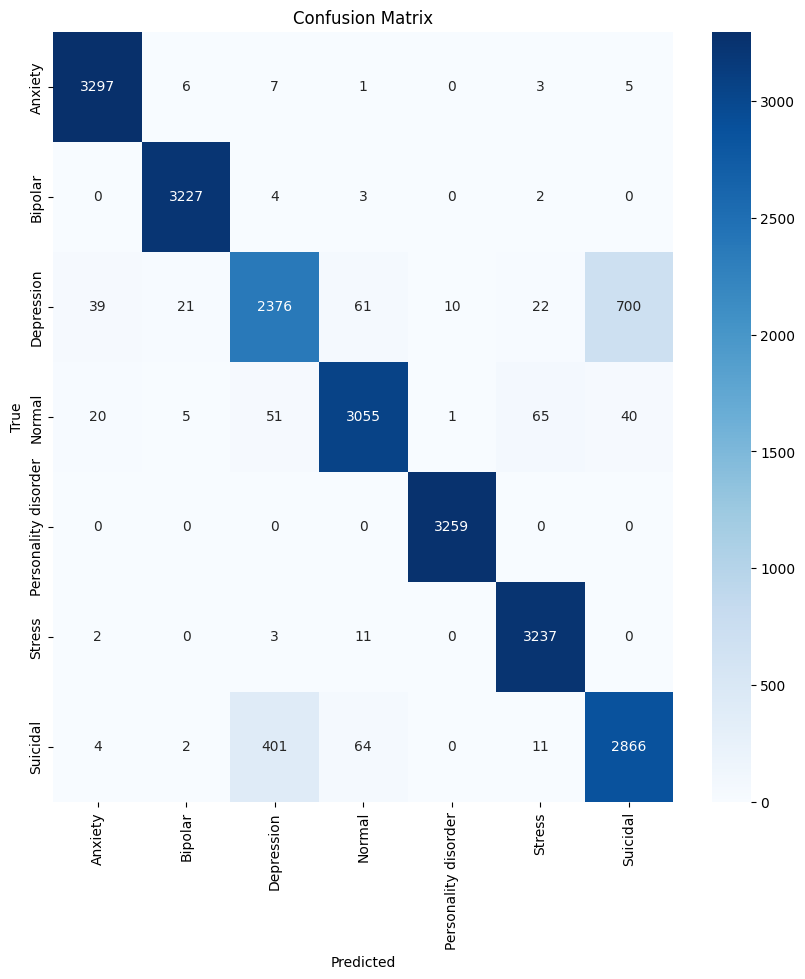

In [47]:
from sklearn.metrics import confusion_matrix

prediction_output = trainer.predict(test_dataset)
predictions_logits = prediction_output.predictions
true_labels = prediction_output.label_ids

predicted_labels = np.argmax(predictions_logits, axis = 1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

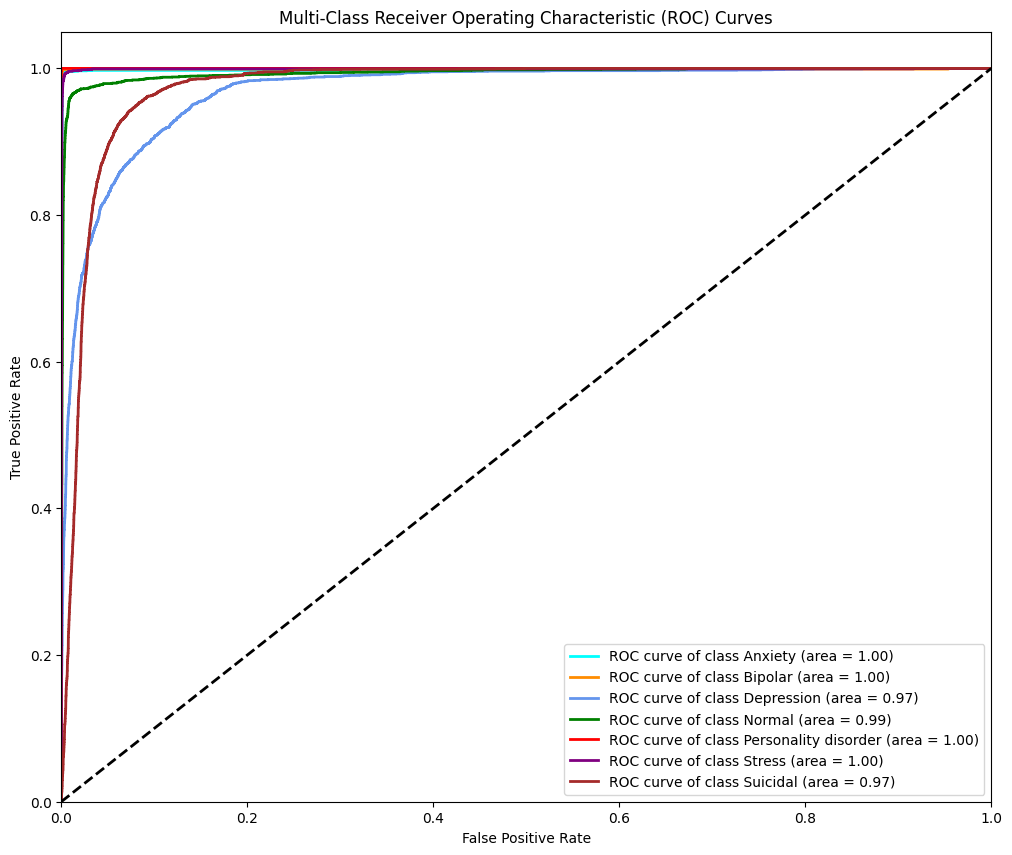

In [48]:
# --- 4. Plot Multi-Class ROC Curves ---
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# This assumes 'label_encoder', 'labels_flat', and 'test_preds' are in memory

# 1. Binarize the true labels (e.g., [0, 1, 0, 0, 0, 0, 0])
y_test_bin = label_binarize(labels_flat, classes=range(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

# 2. Get the raw prediction probabilities (not just the final label)
y_score = test_preds.predictions

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot all ROC curves
plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

# Plot the "random chance" line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Save and Load Model

In [49]:
# 1. Define a relative path (no leading "/") for your BERT model
bert_save_directory = "my_saved_bert_model"

# 2. Save both the model and the tokenizer to that folder
print(f"Saving BERT model to: {bert_save_directory}")
trainer.save_model(bert_save_directory)
tokenizer.save_pretrained(bert_save_directory)
print("Save complete.")

Saving BERT model to: my_saved_bert_model
Save complete.


In [15]:
# --- 1. Define file paths ---
bert_save_directory = "my_saved_bert_model"
encoder_path = "label_encoder.pkl"

# --- 2. Load all components ---
try:
    print(f"Loading model from: {bert_save_directory}")
    model = AutoModelForSequenceClassification.from_pretrained(bert_save_directory)
    tokenizer = AutoTokenizer.from_pretrained(bert_save_directory)
    label_encoder = pickle.load(open(encoder_path, 'rb'))
    
    # --- 3. Set up device (GPU or CPU) ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) # Move the model to the detected device
    
    print(f"Model, tokenizer, and encoder loaded. Using device: {device}")

except FileNotFoundError:
    print(f"--- ERROR: Could not find model files! ---")
    print(f"Please make sure '{bert_save_directory}' and '{encoder_path}' exist in your project folder.")

# --- 4. Define your NEW detection function ---
# This version DOES NOT use clean_statement
def detection(text):
    # This function sends the raw text to the tokenizer.
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=200)
    
    # Move inputs to the GPU/CPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # FIX: Remove token_type_ids for DistilBert
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']
        
    # Get prediction
    with torch.no_grad(): # We don't need to calculate gradients for inference
      outputs = model(**inputs)
      
    logits = outputs.logits
    prediction_label = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform([prediction_label])

    return predicted_label[0] # Return just the label string

Loading model from: my_saved_bert_model
Model, tokenizer, and encoder loaded. Using device: cuda


# Detection System

In [16]:
import torch

def detection(text):
  inputs = tokenizer(text, return_tensors = 'pt', padding = True, truncation = True, max_length = 200)
  # Remove token_type_ids if present, as DistilBERT models do not use them
  if 'token_type_ids' in inputs:
      del inputs['token_type_ids']
  outputs = model(**inputs)
  logits = outputs.logits
  prediction_label = torch.argmax(logits, dim = 1).item()
  predicted_label = label_encoder.inverse_transform([prediction_label])

  return predicted_label

In [56]:
## Google Translate

In [17]:
# Set up the Google Translator
translator = GoogleTranslator(source='auto', target='en')
print("Translator is ready.")

Translator is ready.


In [18]:
# --- Cell 2: Load Your Saved Model & Define CORRECT Detection Function ---

# --- 1. Define file paths ---
bert_save_directory = "my_saved_bert_model"
encoder_path = "label_encoder.pkl"

# --- 2. Load all components ---
try:
    print(f"Loading model from: {bert_save_directory}")
    model = AutoModelForSequenceClassification.from_pretrained(bert_save_directory)
    tokenizer = AutoTokenizer.from_pretrained(bert_save_directory)
    label_encoder = pickle.load(open(encoder_path, 'rb'))
    
    # --- 3. Set up device (GPU or CPU) ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) # Move the model to the detected device
    
    print(f"Model, tokenizer, and encoder loaded. Using device: {device}")

except FileNotFoundError:
    print(f"--- ERROR: Could not find model files! ---")
    print(f"Please make sure '{bert_save_directory}' and '{encoder_path}' exist in your project folder.")

# --- 4. Define your NEW detection function ---
# This version moves the inputs to the correct device
def detection(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=200)
    
    # --- THIS IS THE FIX ---
    # Move the inputs to the same device as the model (e.g., the GPU)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # FIX: Remove token_type_ids for DistilBert
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']
        
    # Get prediction
    with torch.no_grad():
      outputs = model(**inputs)
      
    logits = outputs.logits
    prediction_label = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform([prediction_label])

    return predicted_label[0]

Loading model from: my_saved_bert_model
Model, tokenizer, and encoder loaded. Using device: cuda


In [21]:
# --- Cell 4: Define the Master "predict_sentiment" Function ---
# to test single text line

def predict_sentiment(input_text):
    """
    Analyzes a text string, translates it if it's not English,
    and then predicts its sentiment.
    """
    print(f"Original Text: '{input_text}'")
    text_to_predict = ""

    try:
        detected_lang = detect(input_text)
        if detected_lang == 'en':
            print(f"  -> Language: {detected_lang}. Skipping translation.")
            text_to_predict = input_text
        else:
            print(f"  -> Language: {detected_lang}. Translating to English...")
            text_to_predict = translator.translate(input_text)
            print(f"  -> Translated: '{text_to_predict}'")

    except Exception as e:
        print(f"  -> Language detection failed ({e}).")
        print("  -> Assuming text is not English. Translating...")
        try:
            text_to_predict = translator.translate(input_text)
            ##print(f"  -> Translated: '{text_to_predict}'")
        except Exception as trans_e:
            print(f"   -> Translation ALSO failed: {trans_e}")
            return "Error: Translation failed"

    if text_to_predict:
        try:
            prediction = detection(text_to_predict) # Calls the fixed function
            return prediction
        except Exception as pred_e:
            print(f"\n  -> Prediction Failed: {pred_e}")
            return "Error: Prediction failed"
    else:
        return "Error: No text to predict"

In [19]:
# --- Cell 5: Define a "Silent" Prediction Function for Batch Processing ---
## to test for big file

def predict_sentiment_silent(input_text):
    """
    A silent version of predict_sentiment.
    It takes text, handles translation, and returns the prediction.
    No print statements are used, for clean batch processing.
    """
    text_to_predict = ""
    
    try:
        # 1. Detect the language
        detected_lang = detect(str(input_text)) # Use str() for safety
        
        # 2. Check if the language is English
        if detected_lang == 'en':
            text_to_predict = input_text
        else:
            text_to_predict = translator.translate(str(input_text))

    except Exception as e:
        # If detection fails, assume it needs translation
        try:
            text_to_predict = translator.translate(str(input_text))
        except Exception as trans_e:
            return "Error: Translation Failed" # Return error on failure

    # 3. Run prediction on the final text
    if text_to_predict:
        try:
            # Here it calls the 'detection' helper function
            prediction = detection(text_to_predict)
            return prediction
        except Exception as pred_e:
            return "Error: Prediction Failed" # Return error on failure
    else:
        return "Error: No Text"

print("Silent prediction function is ready.")

Silent prediction function is ready.


In [22]:
text = "အသက်ရှင်နေတာထက် သေသွားတာ ပိုကောင်းမယ်"
prediction = predict_sentiment(text)
print(f"  -> FINAL PREDICTION: {prediction}")

Original Text: 'အသက်ရှင်နေတာထက် သေသွားတာ ပိုကောင်းမယ်'
  -> Language detection failed (No features in text.).
  -> Assuming text is not English. Translating...
  -> FINAL PREDICTION: Suicidal


In [34]:
text = "အိပ်မပျော်ခြင်း၊ စိတ်ရှုပ်ထွေးခြင်း၊ နှလုံးမငြိမ်ခြင်း အားလုံးက အသံမထွက်"
prediction = predict_sentiment(text)
print(f"  -> FINAL PREDICTION: {prediction}")

Original Text: 'အိပ်မပျော်ခြင်း၊ စိတ်ရှုပ်ထွေးခြင်း၊ နှလုံးမငြိမ်ခြင်း အားလုံးက အသံမထွက်'
  -> Language detection failed (No features in text.).
  -> Assuming text is not English. Translating...
  -> FINAL PREDICTION: Anxiety


In [64]:
text = "I’m so fucking lonely. I have no one to talk to. My family doesn’t understand me. The only friend I have doesn’t really understand me. I’m 33, single, no kids. This isn’t what I thought life was going to be. I hate myself. I feel like I’m going to be alone forever and just completely unworthy of love. I just don’t see the point in living if it’s going to be like this. I have nothing to look forward to ever. Everyday I just feel like I’m at the bottom of a black cave and when I try to climb up even slightly I get ripped back down. I just wish I could sleep and not wake up."
prediction = predict_sentiment(text)
print(f"  -> FINAL PREDICTION: {prediction}")

Original Text: 'I’m so fucking lonely. I have no one to talk to. My family doesn’t understand me. The only friend I have doesn’t really understand me. I’m 33, single, no kids. This isn’t what I thought life was going to be. I hate myself. I feel like I’m going to be alone forever and just completely unworthy of love. I just don’t see the point in living if it’s going to be like this. I have nothing to look forward to ever. Everyday I just feel like I’m at the bottom of a black cave and when I try to climb up even slightly I get ripped back down. I just wish I could sleep and not wake up.'
  -> Language: en. Skipping translation.
  -> FINAL PREDICTION: Depression


In [79]:
##Put the name of your new CSV file here
csv_file_name = "scraped_data.csv" 

try:
    df_scraped = pd.read_csv(csv_file_name)
    
    # 2. IMPORTANT: Look at the output to find your text column
    print(f"Successfully loaded '{csv_file_name}'. Here are the first 5 rows:")
    print("Find the name of the column that has the post text (e.g., 'text', 'post', 'comment').")
    display(df_scraped.head())

except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"I could not find the file '{csv_file_name}' in your project folder.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded 'scraped_data.csv'. Here are the first 5 rows:
Find the name of the column that has the post text (e.g., 'text', 'post', 'comment').


,text
0,NaN
1,i dont work hard to prove i got it.. i work ha...
2,You need YOU more than you need EM. Keep grind...
3,"when you get a new beginning, promise yourself..."
4,NaN


In [83]:
# --- Cell 7: Run Predictions on the Entire CSV File ---

# 1. IMPORTANT: Change this to the real column name from your CSV
# (e.g., 'text', 'post', 'comment_text')
text_column_name = 'text' 

if 'df_scraped' in locals() and text_column_name in df_scraped.columns:
    print(f"Running predictions on the '{text_column_name}' column...")
    
    # 2. Apply the silent prediction function to every row
    # This might take a while if your file is big!
    df_scraped['sentiment_prediction'] = df_scraped[text_column_name].apply(predict_sentiment_silent)
    
    print("...Predictions are complete!")

elif 'df_scraped' not in locals():
    print("Error: Please run Cell 6 first to load the data.")
else:
    print(f"--- ERROR: Column Not Found ---")
    print(f"I could not find a column named '{text_column_name}' in your CSV.")
    print(f"Available columns are: {list(df_scraped.columns)}")

Running predictions on the 'text' column...
...Predictions are complete!


In [84]:
# --- Cell 8: Review the Final Results ---

if 'sentiment_prediction' in df_scraped.columns:
    print("--- Predictions Head ---")
    # Show the text and the new prediction side-by-side
    display(df_scraped[[text_column_name, 'sentiment_prediction']].head())
    
    print("\n--- Summary of All Predictions ---")
    # Show a count of each predicted category
    print(df_scraped['sentiment_prediction'].value_counts())
    
    # (Optional) Save your new file with predictions
    df_scraped.to_csv("scraped_data_with_predictions.csv")
    print("\nSaved a new file: 'scraped_data_with_predictions.csv'")
    
else:
    print("Error: Please run Cell 7 first to generate the predictions.")

--- Predictions Head ---


,text,sentiment_prediction
0,NaN,Normal
1,i dont work hard to prove i got it.. i work ha...,Normal
2,You need YOU more than you need EM. Keep grind...,Normal
3,"when you get a new beginning, promise yourself...",Normal
4,NaN,Normal



--- Summary of All Predictions ---
sentiment_prediction
Normal        16
Depression     2
Suicidal       2
Name: count, dtype: int64

Saved a new file: 'scraped_data_with_predictions.csv'
